# Using Jupyter Notebooks with SICStus Prolog

This notebook gives an introduction to the usage of SWI-Prolog in a Jupyter notebook with the
[Prolog Jupyter Kernel](https://github.com/anbre/prolog-jupyter-kernel).<br>

The main requirement for the Prolog Jupyter kernel was for the usage to replicate the Prolog REPL as closely as possible.<br>
Therefore, any code to be executed needs to be **valid Prolog code** and the output mostly resembles the console output.<br>
Additionally, some Jupyter specific messages are printed such as information about the Prolog server (which is responsible for code execution) being halted or restarted.<br>

A code cell can contain **multiple Prolog terms**.<br>
Each of these terms can be a clause definition, directive, or query.<br>
Any variable bindings or other output produced by the terms is displayed in the cell's output.<br>

A main difference compared to the usage in a console is that no user interaction is possible.<br>
Therefore, [computing further solutions](#multiple_solutions) for a goal needs to be handled differently.<br>
Additionally, [debugging](#debugging) cannot be executed as usual.<br>
A major advantage over using a Prolog REPL is that [predicate (re-)definition](#predicate_definition) is more straightforward.<br>
Another convenience the kernel provides is that if the last term of a cell is missing the **terminating full-stop**, the code can be executed anyway. <br>

## Kernel Configuration <a id='kernel_configuration'></a>

The Prolog implementation with which the Prolog Jupyter kernel executes code can be configured (see the [configuration options of the Prolog kernel](https://github.com/anbre/prolog-jupyter-kernel#configuration)).<br>
Without any configuration, code cells are executed with **SWI-Prolog** by default.<br>
In order for this notebook to be executed with SICStus Prolog by default, the configuration file [prolog_kernel_config.py](prolog_kernel_config.py) is needed.

In addition to configuring the Prolog implementation, it can be changed on the fly with `jupyter:set_prolog_impl(+PrologImplementationID)` (see [Change the Prolog Implementation](#changing_prolog_implementation)).<br>
In order for this to work, implementation specific data needs to be configured for more than one Prolog implementation.

For an example of the usage of the kernel with **SWI-Prolog**, see [using_jupyter_notebooks_with_swi_prolog.ipynb](../swi/using_jupyter_notebooks_with_swi_prolog.ipynb).

## Overview

This notebook is structured by the features the Prolog kernel provides.<br>
For each of them, examples are provided which show some possible use cases.<br>
Furthermore, possible peculiarities are explained.

Some of the features correspond to particularities of Prolog that stem from using SLD-resolution as its execution mechanism.<br>
Others are non-standard features that are available in almost every Prolog implementation.<br>
Additionally, there is kernel specific functionality which is provided mostly for user convenience.

Prolog Particularities:
- [Predicate (Re-)Definition](#predicate_definition)
- [Query Execution](#query_execution)
- [Handling Multiple Solutions](#multiple_solutions)

De-Facto Standard Prolog Features:
- [Loading Source Files and Libraries](#load)
- [Running Automated Tests](#automated_tests)
- [Benchmarking Capabilities](#benchmarking)
- [Debugging](#debugging)

Jupyter Convenience Features
- [Introspection](#introspection)
    - [Code completion](#code_completion)
    - [Inspection](#inspection)
    - [Accessing `juypter` documentation](#jupyter_docs)
- [Resetting the Prolog State](#reset_state)
- [Accessing Previous Results](#previous_results)
- [Structured Output](#structured_output)
- [Printing SLD Trees](#sld_trees)
- [Creating Transition Graphs](#transition_graphs)
- [Changing the Prolog Implementation](#changing_prolog_implementation)

## Prolog Particularities

Each term in a code cell can be a **clause definition**, **directive**, or **query**.<br>
While terms like directives and clauses with bodies can easily be distinguished from queries, it is more difficult for clauses without bodies.<br>

If a cell contains a single potential query, it is interpreted as such instead of a clause definition.<br>
Additionally, terms starting with `?-` or `:-` are evaluated as queries even if the cell contains further terms.<br>
In all other cases, the terms are treated as clause definitions.<br>
For example, a single fact can be defined by writing a term of the form `foo :- true.`.<br>

In each case, the cell output lets the user infer how a term was interpreted.<br>

### Predicate (Re-)Definition <a id='predicate_definition'></a>

In general, all terms of a code cell interpreted as clause definitions are added as **dynamic** facts to the database. <br>
The clauses can be module name expanded such as `Module:Head :- Body.`. <br>
If no module name is defined, the module `user` is chosen by default.<br>
To let the user know the exact predicate that was defined, its specification is output.<br>

In [1]:
my_append([], Res, Res).
my_append([H|T], List, [H|Res]) :-
  my_append(T, List, Res).

% Asserting clauses for user:my_append/3


The use of Prolog in a Jupyter application is meant for **interactive programming**.<br>
This involves writing, testing and rewriting clauses rather than adding new clauses to the fact database.<br>
Therefore, by default, when clauses are defined for a dynamic predicate for which there are existing ones, these are retracted first.<br>
This implies that all clauses of a predicate need to be defined in one cell.<br>

If previous clauses are retracted, the user is informed about the exact clauses.<br>
The message can be expanded in order to see the exact clauses which were retracted.<br>

In [2]:
user:my_append([], Res, Res).
user:my_append([Head|Tail], List, [Head|Res]) :-
  my_append(Tail, List, Res).

Previously defined clauses of user:my_append/3 were retracted:
my_append([], A, A).
my_append([A|B], C, [A|D]) :-
        my_append(B, C, D).

% Asserting clauses for user:my_append/3


To define clauses for a predicate in separate cells instead, the corresponding predicate can be declared **discontiguous** (and dynamic).<br>

For SICStus, declarations need to be handled specially as they must not appear in a query.<br>
All declarations which are to be valid at the same time, need to be defined in a single cell.<br>
Furthermore, a single cell should not contain both, declarations for predicate properties and clauses for the same predicate.<br>
In that case, the clauses cannot be added to the database.<br>

When removing a predicate with `abolish`, its properties are removed as well.<br>
Therefore, afterwards previous clauses are retracted again when new ones are defined.

In [3]:
:- discontiguous fact/1.
:- dynamic fact/1.


% Loaded the declaration file

In [4]:
fact(a).
fact(b).

% Asserting clauses for user:fact/1


In [5]:
fact(c).
fact(d).
?- listing(fact/1).

% Asserting clauses for user:fact/1


fact(a).
fact(b).
fact(c).
fact(d).


yes

Additionally, clauses can be defined in the form of **DCG rules**.

In [6]:
number(Number) --> "+", number(Number).
number(NegativeNumber) --> "-", number(Number), {NegativeNumber is -Number}.
number(Number) --> [Digit], {"0"=<Digit, Digit=<"9", Number is Digit - "0"}.

?- atom_codes('-1', _Codes), phrase(number(N), _Codes).

% Asserting clauses for user:number/3


N = -1

### Query Execution <a id='query_execution'></a>

If a query succeeds and binds any variables, the **bindings** are shown in the output of the cell.<br>
Analogously, if there are no bindings, `true` is printed and if a query fails, `false` is output.<br>

In [7]:
X = [1,2,3], append(X, [4,5,6], Z).

X = [1,2,3],
Z = [1,2,3,4,5,6]

In [ ]:
?- member(2, [1, 2, 3]).
?- member(4, [1, 2, 3])

yes

no

Just like in a Prolog REPL, no variable bindings are output for **directives**.

In [9]:
:- member(M, [1, 2, 3]), print(M).

1

If a query causes an **exception**, the exception message is printed in red.

In [ ]:
7 is 1 + y.

! Type error in argument 2 of (is)/2
! expected evaluable, but found y/0
! goal:  7 is 1+y


In any case, if the execution produces **output**, it is displayed preceding the other information.

In [11]:
format('Using ~w Prolog!~n', ['SICStus']).

Using SICStus Prolog!

yes

### Handling Multiple Solutions <a id='multiple_solutions'></a>

Usually, when a query succeeds with a choicepoint, further solutions can be requested via **backtracking**.<br>
Since that is not possible in the same way in a Jupyter application, the predicate `jupyter:retry/0` is implemented to mimic this instead.<br>
Whenever a query is executed, it is seen as the **active goal** as long as there might be further solutions for it.<br>

If there is an active query, by calling the `retry` predicate in a following query (which is possible in the same cell), backtracking may be triggered to compute the next solution.<br>
In order to let the user know which query is retried, a corresponding message is output.<br>

In [12]:
?- member(M, [1, 2]).
?- member(M, [a, b, c]).

M = 1

M = a

In [13]:
jupyter:retry.

% Retrying goal: member(M,[a,b,c])


M = b

As a user may wish to see the **stack of queries** which can be retried, the predicate `jupyter:print_stack/0` can be called to output them.<br>
The currently active query is printed at the top and marked by a preceding arrow.<br>

In [14]:
jupyter:print_stack

->  member(M,[a,b,c])
    member(M,[1,2])
    format(Using ~w Prolog!~n,[SICStus])
    member(2,[1,2,3])
    X=[1,2,3],append(X,[4,5,6],Z)
    atom_codes(-1,_Codes),phrase(number(N),_Codes)
    listing(fact/1)

yes

Additionally, there is the predicate `jupyter:cut/0` to **cut off choicepoints** of the active execution.<br>
A previous query which might have open choicepoints is set as active, and the user is informed about the new active goal.<br>

In [15]:
?- cut.
?- retry.

% The new active goal is: member(M,[1,2])

yes

% Retrying goal: member(M,[1,2])


M = 2

Since backtracking is a Prolog feature which is used frequently, the `retry` and `cut` predicates can also be called without the module name expansion and cannot be redefined in the `user` module.<br>
Note that these predicates as well as `jupyter:print_stack/0` do not work unless they are the only goal in a term.<br> 

#### Backtracking Example

The `retry` and `cut` mechanism can be useful when:
- Computing the solution of a query
- Further inspecting the solution with a different query
- Computing the next solution and further inspecting it

This is especially useful when the computation of the first solution took so long that it should not be executed again.

For an explanation of `$Var` terms, see [Accessing Previous Results](#previous_results).


In [16]:
is_odd(X) :-
  1 is X mod 2.
  
% Assume that the computation of HighlyComplexListResult took a long time. 
% Therefore, it should not be computed again.
?- HighlyComplexListResult = [1, 2, 3, 4, 5].

% Asserting clauses for user:is_odd/1


HighlyComplexListResult = [1,2,3,4,5]

In [17]:
?- member(M, $HighlyComplexListResult).

M = 1,
HighlyComplexListResult = [1,2,3,4,5]

In [18]:
is_odd($M).

M = 1

In [ ]:
?- cut.
?- retry.
?- is_odd($M).

% The new active goal is: member(M,[1,2,3,4,5])

yes

% Retrying goal: member(M,[1,2,3,4,5])


M = 2,
HighlyComplexListResult = [1,2,3,4,5]

no

Note that this time no `cut` is needed because the previous query failed and therefore did not produce a choicepoint.

In [20]:
?- retry.
?- is_odd($M).

% Retrying goal: member(M,[1,2,3,4,5])


M = 3,
HighlyComplexListResult = [1,2,3,4,5]

M = 3

## De-Facto Standard Prolog Features

### Loading Source Files and Libraries <a id='load'></a>

Principally, source files and libraries can be loaded in the same way as in a REPL.<br>
However, since user interaction is not possible, predicates are always re-defined instead of leaving the decision to the user.<br>

In [21]:
use_module(library(lists)).

% module lists imported into user

yes

In [22]:
append([[1], [2], [3]], L). 

L = [1,2,3]

Note that loading a library and using operators from that library does not work in a single cell.<br>
The terms need to be read in first, which causes a syntax error when encountering the yet undefined operators.

In [ ]:
?- use_module(library(clpfd)).
?- X #< 10, X #> 5.

! Syntax error in read_term/3
! operator expected after expression
! in line 2
! ?- X 
! <<here>>
! #< 10 , X #> 5 . 


In [24]:
use_module(library(clpfd)).

% loading /usr/local/sicstus4.5.1/bin/sp-4.5.1/sicstus-4.5.1/library/clpfd.po...
% module clpfd imported into user
%  loading /usr/local/sicstus4.5.1/bin/sp-4.5.1/sicstus-4.5.1/library/atts.po...
%  module attributes imported into clpfd
%   module types imported into attributes
%  loaded /usr/local/sicstus4.5.1/bin/sp-4.5.1/sicstus-4.5.1/library/atts.po in module attributes, 3 msec 30512 bytes
%  compiling /usr/local/sicstus4.5.1/bin/sp-4.5.1/sicstus-4.5.1/library/avl.pl...
%   module avl imported into clpfd
%  compiled /usr/local/sicstus4.5.1/bin/sp-4.5.1/sicstus-4.5.1/library/avl.pl in module avl, 16 msec 64992 bytes
%  module lists imported into clpfd
%  loading /usr/local/sicstus4.5.1/bin/sp-4.5.1/sicstus-4.5.1/library/ordsets.po...
%  module ordsets imported into clpfd
%  loaded /usr/local/sicstus4.5.1/bin/sp-4.5.1/sicstus-4.5.1/library/ordsets.po in module ordsets, 2 msec 45904 bytes
%  loading /usr/local/sicstus4.5.1/bin/sp-4.5.1/sicstus-4.5.1/library/trees.po...
%  module trees

yes

In [25]:
X #< 10, X #> 5.

X in 6..9

### Running Automated Tests <a id='automated_tests'></a>

Automated tests can be defined and run with `library(plunit)`.<br>
Tests can either be defined in a **file** which is loaded or in a **cell**.<br>
In the latter case, any definition of a `test/1` or `test/2` clause needs to be preceded by a `begin_tests` directive.<br>
Additionally, if there is an optional `end_tests` directive, it has to follow the test clauses.<br>
Otherwise, they are not recognized as such.

In [26]:
:- begin_tests(list). 

test(list) :-
  lists:is_list([]).

:- end_tests(list).

% compiling /media/storage/Uni/Masterarbeit/prolog_kernel/notebooks/feature_introduction/sicstus/jupyter_tests.pl...
%  loading /usr/local/sicstus4.5.1/bin/sp-4.5.1/sicstus-4.5.1/library/plunit.po...
%  module plunit imported into user
%   module lists imported into plunit
%   module types imported into plunit
%  loaded /usr/local/sicstus4.5.1/bin/sp-4.5.1/sicstus-4.5.1/library/plunit.po in module plunit, 6 msec 129280 bytes
% compiled /media/storage/Uni/Masterarbeit/prolog_kernel/notebooks/feature_introduction/sicstus/jupyter_tests.pl in module user, 10 msec 157520 bytes
% Loaded the test file

In [27]:
run_tests.

% PL-Unit: list 
% /media/storage/Uni/Masterarbeit/prolog_kernel/notebooks/feature_introduction/sicstus/jupyter_tests.pl:2:
% 	test list: succeeded (det) in 0.00 seconds
% done
% 1 tests passed

yes

It needs to be noted that after defining new test clauses in a different cell, tests units of previous ones still exist, but not the tests themselves.<br>
Therefore, all tests which are to be run at the same time need to be defined in one cell.<br>

In [28]:
:- begin_tests(number). 

test(number_failing, [fail]) :-
  number([]).
  
?- run_tests.

% compiling /media/storage/Uni/Masterarbeit/prolog_kernel/notebooks/feature_introduction/sicstus/jupyter_tests.pl...
% compiled /media/storage/Uni/Masterarbeit/prolog_kernel/notebooks/feature_introduction/sicstus/jupyter_tests.pl in module user, 3 msec 3040 bytes
% Loaded the test file

% PL-Unit: list 
% done
% PL-Unit: number 
% /media/storage/Uni/Masterarbeit/prolog_kernel/notebooks/feature_introduction/sicstus/jupyter_tests.pl:2:
% 	test number_failing: succeeded (det) in 0.00 seconds
% done
% 1 tests passed

yes

As mentioned above, test definitions can also be loaded from a **file** and redefinitions of predicates are always performed.<br>
A file containing `plunit` test clauses defines the predicates `'unit body'/4` and `'unit test'/5`.<br>
If test files with different names are loaded, these predicates are redefined and corresponding messages are output.<br>
When defining tests in a cell, they are written to a file named `jupyter_tests.pl` which is loaded.<br>
Since this file is named the same for every cell containing tests, when running multiple cells with test definitions, the redefinition warnings are not output for every execution.<br>

In [29]:
[test].

% compiling /media/storage/Uni/Masterarbeit/prolog_kernel/notebooks/feature_introduction/sicstus/test.pl...
* The procedure 'unit body'/4 is being redefined.
*     Old file: /media/storage/Uni/Masterarbeit/prolog_kernel/notebooks/feature_introduction/sicstus/jupyter_tests.pl
*     New file: /media/storage/Uni/Masterarbeit/prolog_kernel/notebooks/feature_introduction/sicstus/test.pl
* Approximate lines: 12-13, file: '/media/storage/Uni/Masterarbeit/prolog_kernel/notebooks/feature_introduction/sicstus/test.pl'
% compiled /media/storage/Uni/Masterarbeit/prolog_kernel/notebooks/feature_introduction/sicstus/test.pl in module user, 3 msec 8480 bytes

yes

In [30]:
run_tests.

% PL-Unit: list 
% done
% PL-Unit: number 
% done
% PL-Unit: test 
% /media/storage/Uni/Masterarbeit/prolog_kernel/notebooks/feature_introduction/sicstus/test.pl:13:
% 	test a: succeeded (det) in 0.00 seconds
% /media/storage/Uni/Masterarbeit/prolog_kernel/notebooks/feature_introduction/sicstus/test.pl:16:
% 	test b: succeeded (det) in 0.00 seconds
% /media/storage/Uni/Masterarbeit/prolog_kernel/notebooks/feature_introduction/sicstus/test.pl:19:
% 	test c: succeeded (det) in 0.00 seconds
% done
% 3 tests passed

yes

### Benchmarking Capabilities <a id='benchmarking'></a>

In [31]:
member(M, [1,2,3]).

M = 1

Whenever a query is executed, its runtime is stored in a database.<br>
It can be accessed by calling `jupyter:print_query_time`, which prints the latest previous query and its runtime in milliseconds.<br>

In [32]:
jupyter:print_query_time.

Query:   member(M,[1,2,3])
Runtime: 0 ms

yes

### Debugging <a id='debugging'></a>

In a Jupyter notebook, debugging cannot be performed interactively as user input is not supported.<br>
Thus, the predicate `jupyter:trace(Goal)` was implemented.<br>
It switches on trace mode, calls the goal `Goal` and switches debug mode off.<br>
To be recognized as a special goal, it needs to be the only one in a term.<br>

By default, all ports are unleashed and included in the output, which means that no user interaction is requested when a breakpoint is activated.<br>

In [33]:
app([], Res, Res).
app([Head|Tail], List, [Head|Res]) :-
  app(Tail, List, Res).
  
app(L1, L2, L3, Res) :-
  app(L2, L3, R1),
  app(L1, R1, Res).  

% Asserting clauses for user:app/3


% Asserting clauses for user:app/4


In [34]:
jupyter:trace(app([1], [2], R)).

        1      1 Call: app([1],[2],_564523)
        2      2 Call: app([],[2],_568321)
        2      2 Exit: app([],[2],[2])
        1      1 Exit: app([1],[2],[1,2])

R = [1,2]


The leashing mode does not apply to breakpoints.<br>
If a breakpoint is created which requires user interaction, the Prolog server has to be restarted after that breakpoint's activation.<br>
In order to prevent this, a breakpoint should be created with the option `proceed` so that on activation the execution is continued without stopping.<br>

In [35]:
add_breakpoint(pred(app/3)-[print-[1], proceed], _). % print the first argument in the debugging message

% The debugger will first zip -- showing spypoints (zip)
% Conditional spypoint for user:app/3 added, BID=1

yes

In [36]:
app([1], [2], R).

 *      4      1 Call: ^1 [1]
 *      5      2 Call: ^1 []
 *      5      2 Exit: ^1 []
 *      4      1 Exit: ^1 [1]

R = [1,2]

All created breakpoints are still active during a `jupyter:trace/1` call.

In [37]:
jupyter:trace((app([1], [2], [3], [1,2,3]))).

        6      1 Call: app([1],[2],[3],[1,2,3])
 *      7      2 Call: ^1 [2]
 *      8      3 Call: ^1 []
 *      8      3 Exit: ^1 []
 *      7      2 Exit: ^1 [2]
 *      9      2 Call: ^1 [1]
 *     10      3 Call: ^1 []
 *     10      3 Exit: ^1 []
 *      9      2 Exit: ^1 [1]
        6      1 Exit: app([1],[2],[3],[1,2,3])

yes

## Jupyter Convenience Features

### Introspection <a id='introspection'></a>

#### Code Completion (Tab) <a id='code_completion'></a>

In JupyterLab as well as Jupyter Notebook, code completion for the token at the current cursor position can be requested by pressing the *Tab* key.<br>
If there is a single possible match, the code preceding the cursor is replaced directly.<br>
Otherwise, a list of options is shown from which the user can choose one.<br>

Completion can be used for predicates which are **built-in** or **exported by a currently loaded module**.<br>
After loading another module, the completion data needs to be updated with `jupyter:update_completion_data/0`.<br>
Otherwise, completion does not work for predicates from that module.<br>

The predicate terms with which the current token is compared and replaced are module name expanded.<br>
Therefore, it is possible to see all predicates of a module.<br>
This is especially useful for retrieving all special predicates defined by the module `jupyter`.<br>

In [38]:
jupyter:update_completion_data.

yes

#### Inspection (Shift+Tab) <a id='inspection'></a>

By pressing *Shift+Tab*, inspection for the token preceding the current cursor position is requested.<br>
For SWI-Prolog, the **documentation** is retrieved with `help/1` and shown right away.<br>
Additionally, documentation for predicates from module `jupyter` is provided by the module itself and is displayed at the bottom of the text.

Note that in contrast to completion, in this case, the module name expansion is removed before fetching the documentation.


#### Accessing `jupyter` documentation <a id='jupyter_docs'></a>

In JupyterLab as well as Jupyter Notebook, code completion for the token at the current cursor position can be requested by pressing the *Tab* key.<br>
If there is a single possible match, the code preceding the cursor is replaced directly.<br>
Otherwise, a list of options is shown from which the user can choose one.<br>

Completion can be used for predicates which are **built-in** or **exported by a currently loaded module**.<br>
After loading another module, the completion data needs to be updated with `jupyter:update_completion_data/0`.<br>
Otherwise, completion does not work for predicates from that module.<br>

The predicate terms with which the current token is compared and replaced are module name expanded.<br>
Therefore, it is possible to see all predicates of a module.<br>
This is especially useful for retrieving all special predicates defined by the module `jupyter`.<br>

In [39]:
jupyter:update_completion_data.

yes

Most of the features below are provided by the module `jupyter`.<br>
In addition to inspection, the documentation of all predicates defined in this module can be accessed with `jupyter:help/0`.<br>

If the predicate is called without the module name expansion and it is not defined in the current module `user`, the corresponding error message is displayed followed by a note that there is `jupyter:help/0`.<br>
However, if `user:help/0` is defined, calling it works as expected without any special output for the `jupyter` predicate.<br>

In [ ]:
help.

! Existence error in user:help/0
! procedure user:help/0 does not exist
! goal:  user:help
! 
! However, there is the predicate jupyter:help/0


In [41]:
jupyter:help

jupyter:cut or cut

    Cuts off the choicepoints of the latest active query.

    In general, the previous query is the active one.
    However, the previous active query can be activated again.
    This can be done by cutting off choicepoints with jupyter:cut/0.
    This is also the case if a retry/0 encounters no further solutions.

    A further retry/0 call causes backtracking of the previous active goal.

    Needs to be the only goal of a query.

--------------------------------------------------------------------------------

jupyter:halt or halt

    Shuts down the running Prolog process.

    The next time code is to be executed, a new process is started.
    Everything defined in the database before does not exist anymore.

    Corresponds to the functionality of halt/0.
    Has the same effect as interrupting or restarting the Jupyter kernel.

--------------------------------------------------------------------------------

jupyter:help

    Outputs the documentation for al

yes

### Resetting the Prolog State <a id='reset_state'></a>

All code is executed by a Prolog server.<br>
As long as the server is running, the database state with all potential side effects such as clause assertions is active.<br>
However, the user might want to undo all those and **reset everything to a clean state**.<br>
This is especially useful when all cells of a notebook are to be run, but not all of them are supposed to work with the same Prolog database.<br>
There are several ways to do this.<br>

The most Prolog-like way is to call the built-in predicate `halt` or the special kernel version `jupyter:halt`.<br>
In order to be identified as special predicates and processed correctly, they need to be the only goal of a query.<br>
If the handling does work as expected, a success message is output.<br>

Additionally, the Jupyter notebook applications provide **buttons** for interrupting or restarting the kernel.<br>
The same can also be achieved by pressing *I+I* and *0+0* respectively.<br>

All of these options cause the Prolog server to be stopped.<br>
The next time code is executed, it needs to be restarted.<br>
In that case, a message is output to let the user know that everything defined so far has been undone.<br>

In [42]:
halt.

% Successfully halted

After the server restart, the previously defined predicate `app/4` does not exist anymore.

In [ ]:
my_append([1,2], [3,4], R).

% The Prolog server was restarted

! Existence error in user:my_append/3
! procedure user:my_append/3 does not exist
! goal:  user:my_append([1,2],[3,4],_17641)


### Accessing Previous Results <a id='previous_results'></a>

SWI-Prolog provides functionality of reusing top-level bindings.<br>
Roughly, when a top-level goal succeeds, its bindings are asserted in a database.<br>
By using `$Var` in a top-level query, the **latest binding** for the variable `Var` can be accessed.<br>
This functionality is also provided by the SICStus Prolog Jupyter kernel.<br>

In [44]:
halt.

% Successfully halted

In [45]:
X = 1.

% The Prolog server was restarted

X = 1

In [46]:
Y is $X + 2.

Y = 3,
X = 1

Additionally, there is the predicate `jupyter:print_variable_bindings/0` that outputs all stored variable bindings.<br>

In [47]:
jupyter:print_variable_bindings.

$X =        1
$Y =        3

yes

#### Collecting Previous Queries

Further, all executed queries are stored internally.<br>
When writing a new predicate, a user might **test its subgoals gradually** in separate cells, potentially using `$Var` terms to access previous results.<br>
Once all the parts are written, the predicate `jupyter:print_queries(Ids)` can be called to access the previous queries from cells with IDs in the list `Ids`.<br>
They are printed in a way that they can easily be copied to a cell and executed right away or expanded with a head to define a predicate.<br>
If a query contains a `$Var` term and one of the previously printed queries contains the variable `Var`, the term is replaced by the variable name.<br>

In [48]:
member(Member, [10, 20, 30]).

Member = 10

In [49]:
Square is $Member * $Member.

Square = 100,
Member = 10

In [50]:
jupyter:print_queries([48,49]).

member(Member,[10,20,30]),
Square is Member*Member.

yes

### Structured Output <a id='structured_output'></a>

There are two special predicates to output **tables**.

#### `jupyter:print_table/1`

The predicate `jupyter:print_table(Goal)` can be used to compute all results of the goal `Goal` with **`findall/3`** and display them in a table.<br>
The table contains a column for each variable occurring in it and a line for each result.<br>

In [51]:
jupyter:print_table(
  ( member(Member, [10,20]),
    Square is Member*Member)).

Member | Square | 
:- | :- | 
10 | 100 | 
20 | 400 | 

yes

#### `jupyter:print_table/2`

In order to fill a table with other data than results of `findall/3`, there is the predicate `jupyter:print_table(ValuesLists, VariableNames)`.<br>
`ValuesLists` is expected to be a list of lists where each of this lists corresponds to one line of the table.<br>
Therefore, all the lists need to be of the same length.<br>
Furthermore, `VariableNames` is used to provide the column headers and needs to be a list of ground terms of the same length as well unless it equals `[]`.<br>
In the latter case, the headers contain capital letters starting from `A`.<br>

In [52]:
jupyter:print_table([[10,100],[20,400],[30,900]], []).

A | B | 
:- | :- | 
10 | 100 | 
20 | 400 | 
30 | 900 | 

yes

Note that both predicates have to be handled specially and cannot be recognized correctly unless they are the only goal in a query.<br>
Therefore, the value for `ValuesLists` cannot be computed in the same query.<br>
Instead, the mechanism of accessing bindings from previous queries can be used.<br>

In [53]:
findall([M, S], (member(M, [10,20]), S is M*M), ResultLists).

ResultLists = [[10,100],[20,400]]

In [54]:
jupyter:print_table($ResultLists, ['Member', 'Square']).

Member | Square | 
:- | :- | 
10 | 100 | 
20 | 400 | 

yes

### Printing SLD Trees <a id='sld_trees'></a> 

With `jupyter:print_sld_tree(Goal)`, a graph resembling an SLD tree can be output.<br>
In order to be recognized as a special predicate, it needs to be the only goal of a query.<br>
Note that so far, nodes are only output for invocations at **`call`** ports.<br>
Therefore, successful branches cannot be distinguished from failing ones yet.<br>
However, visualizing the called goals in a tree can still facilitate debugging.<br>

In [55]:
app([], Res, Res).
app([Head|Tail], List, [Head|Res]) :-
  app(Tail, List, Res).

app(L1, L2, L3, Res) :-
  app(L2, L3, R1),
  app(L1, R1, Res).

% Asserting clauses for user:app/3


% Asserting clauses for user:app/4


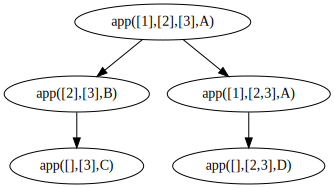

R = [1,2,3]

In [56]:
jupyter:print_sld_tree(app([1], [2], [3], R)).

### Creating Transition Graphs <a id='transition_graphs'></a> 

With `jupyter:print_transition_graph(PredSpec, FromIndex, ToIndex, LabelIndex)`, a different graph can be created.
Again, it needs to be the only goal of a query so that it can be treated specially.
In that case, a graph representing the possible transitions between clauses of the predicate with specification `PredSpec` is created by computing all solutions.

`PredSpec` needs to be of the form `PredName/PredArity` or `Module:PredName/PredArity`.<br>
The index arguments `FromIndex` and `ToIndex` point to predicate arguments used as nodes.<br>
`LabelIndex` points to the argument providing a label for an edge.<br>
If `LabelIndex=0`, no label is shown.<br>

In [57]:
edge(a, 4, b).
edge(a, 3, c).
edge(b, 9, c).

% Asserting clauses for user:edge/3


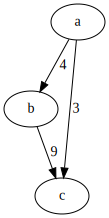

yes

In [58]:
jupyter:print_transition_graph(edge/3, 1, 3, 2).

### Changing the Prolog Implementation <a id='changing_prolog_implementation'></a> 

If implementation-specific data is configured for more than one Prolog implementation (see [Kernel Configuration](#kernel_configuration)), the active Prolog implementation used for code execution can be changed on the fly with `jupyter:set_prolog_impl(+PrologImplementationID)`.<br>
The corresponding goal needs to be the only one of a query, as otherwise the predicate cannot be recognized as a special one.<br>

The implementation is changed after all code of the cell has been executed.<br>
Therefore, any code following a `jupyter:set_prolog_impl/1` query in the same cell is still executed with the previous active implementation.<br>

Furthermore, the server for the previously used implementation is **kept running** so that when changing back, the state has not changed.<br>
For instance, the previous variable bindings still exist.<br>
However, when the Jupyter kernel is interrupted, all running Prolog server processes are killed and need to be restarted the next time code is executed.<br>
If a user wants to restart a single process, `jupyter:halt/0` can be called.<br>

In [59]:
jupyter:set_prolog_impl(swi).

yes

After changing to SWI-Prolog, the previously defined predicate `app/3` does not exist.

In [ ]:
app([1,2], [3], R)

ERROR: call/1: Unknown procedure: app/3


Changing back to SICStus Prolog, the previous state has not changed.<br>
For instance, the defined predicates still exist.

In [61]:
jupyter:set_prolog_impl(sicstus).

true

In [62]:
app([1,2], [3], R)

R = [1,2,3]